__Домашнее задание:__<br>
обучить рукописную сверточную нейронную сеть (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) на датасете cifar-10<br>
оценить рост точности при увеличении ширины сети (больше фильтров)
оценить рост точности при увеличении глубины сети (больше слоев)
*сравнить с точностью полносвязной сети для этой выборки

<br>

Рекомендации по оформлению кода:
исправляя код из ноутбука, указывайте, пожалуйста, где были сделаны изменения, чтобы было легче ориентироваться в коде, к тому же это повысит скорость проверки работы.

__Решение:__

Загружаю библиотеки

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras import models, layers

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D



Загружаю картинки и рабиваю на трейн и тест:

In [43]:

# разделение тренировочной и тестовой выборки
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'тренировочные примеры')
print(X_test.shape[0], 'тестовые примеры')

classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

X_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [44]:
# смотрю диапазон значений в данных, т.к. они не объединены, проверяю и в тесте и в трейне
X_train.min(), X_train.max(), X_test.min(), X_test.max()

(0, 255, 0, 255)

In [45]:
# перевожу таргеты в виде чисел в векторное выражение
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# нормирую данные с учетом увиденных выше макс. значений
X_train = X_train / 255.0
X_test = X_test / 255.0

К примеру возьмем 101-ое изображение и посмотрим что за картинки:

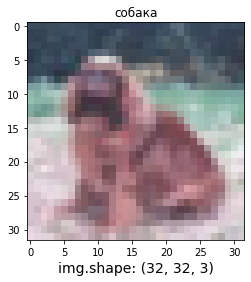

In [46]:
N = 101

plt.imshow(X_test[N])
plt.title(classes[np.argmax(y_test[N,:])])
plt.xlabel(f'img.shape: {X_test[N].shape}', fontsize=14)
plt.show()

Видим картинку 32х32.

__Приступаю к написанию нейросети:__ возьму 3 сверточных слоя и после каждого из них будет пулинговый, далее 2 полносвязных слоя

In [47]:
model = Sequential([
    # сверточные и пуллинговые слои - 3 шт.
    Conv2D(2, (4, 4), padding='same', input_shape=(32, 32, 3)),  # input_shape берем из X_train.shape[1:], ядро берем размером 4х4
    AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),  # padding - обрабатываю края картинки (доп. контурный пискельный ряд по периметру), pool_size 2х2 матрица
    Conv2D(5, (3, 3), padding='same'),  
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), # strides здесь уже будем не каждый подряд пискель ядром 2х2 просматривать, а перепрыгивать ч-з 1
    Conv2D(9, (3, 3), padding='same'),
    AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),

    Flatten(),

    # 2 полносвязных слоя               # полносвязных нужно делать более 1 слоя, чтобы уходить от линейной зависимости
    Dense(120, activation='relu'),
    Dense(80, activation='relu'),

    # выходной слой
    Dense(10, activation='softmax')
    ])  

# компиляция модели
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=["accuracy"])


hist = model.fit(X_train, y_train,
                 epochs=2,
                 batch_size=1000,
                 validation_data=(X_test, y_test),
                 verbose=1)
#model.summary()

Epoch 1/2
50/50 [==============================] - 64s 1s/step - loss: 2.0906 - accuracy: 0.2410 - val_loss: 1.9232 - val_accuracy: 0.3065
Epoch 2/2
50/50 [==============================] - 62s 1s/step - loss: 1.8423 - accuracy: 0.3466 - val_loss: 1.7814 - val_accuracy: 0.3706


Ради эксперимента попробую применить к модели аугментацию и посмотреть на итог:

In [48]:
print('То же самое, но с использованием data augmentation')

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False, 
    zca_epsilon=1e-06, 
    rotation_range=10, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0., 
    zoom_range=0.2, 
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0)


train_gen = datagen.flow(X_train, 
                          y_train,
                          batch_size=1000)

# запуск data augmentation через fit_generator
model.fit(train_gen,
          epochs=2,
          validation_data=(X_test, y_test),
          verbose=1)

То же самое, но с использованием data augmentation
Epoch 1/2
50/50 [==============================] - 81s 2s/step - loss: 1.8025 - accuracy: 0.3583 - val_loss: 1.6806 - val_accuracy: 0.4109
Epoch 2/2
50/50 [==============================] - 72s 1s/step - loss: 1.7325 - accuracy: 0.3816 - val_loss: 1.6236 - val_accuracy: 0.4259


In [49]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 32, 32, 2)         98        
                                                                 
 average_pooling2d_30 (Avera  (None, 32, 32, 2)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 5)         95        
                                                                 
 average_pooling2d_31 (Avera  (None, 16, 16, 5)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 9)         414       
                                                                 
 average_pooling2d_32 (Avera  (None, 16, 16, 9)      

Итак, возьму model как за базовую сеть и далее буду результаты сравнивать с ней.<br>
model генерирует 287 697 признака и accuracy: 0.3466

__На основе базовой модели напишу модель с увеличенной шириной сети (больше фильтров):__

In [53]:
# практики ради буду использовать др. способ написания сети (ручной)

# инициализация  модели
input = layers.Input(shape=(32, 32, 3))

# первый сверточный слой
x1 = layers.Conv2D(6, (4, 4), strides=(1, 1),     # меняю кол-во входных карт(фильтров) с 3 на 6
                   activation='relu',
                   padding="same")(input)

# первый пуллинговый слой
x2 = layers.AveragePooling2D(pool_size=(2, 2),
                             strides=(1, 1),
                             padding='same')(x1)

# второй сверточный слой
x3 = layers.Conv2D(8, (3, 3), strides=(2, 2),    # меняю кол-во входных карт(фильтров) с 5 на 8
                   activation='relu',
                   padding='same')(x2)

# второй пуллинговый слой
x4 = layers.AveragePooling2D(pool_size=(2, 2),
                             strides=(2, 2),
                             padding='same')(x3)

# третий сверточный слой
x5 = layers.Conv2D(9, (3, 3), strides=(1, 1),   # оставлю д т.к. итак должна получиться широкая сеть - увидим в summary()
                   activation='relu',
                   padding='valid')(x4)

# третий пуллинговый слой
x6 = layers.AveragePooling2D(pool_size=(2, 2),
                             strides=(1, 1),
                             padding='same')(x5)



# сглаживание CNN выхода чтобы можно было его присоединить к полносвязногому слою
x7 = layers.Flatten()(x6)

# полносвязный слой                              
x8 = layers.Dense(120, activation='tanh')(x7)
# полносвязный слой
x9 = layers.Dense(80, activation='tanh')(x8)

# выходной слой с функцией активации softmax
out_x = layers.Dense(10, activation='softmax')(x9)


# Соберем полную модель сети от входа к выходу 
model_wider = Model(inputs=input, outputs=out_x)

# сделаем несколько промежуточных выходов (через них посмотрим, что происходит в сети) 
model_1_layer = Model(inputs=input, outputs=x1)
model_3_layer = Model(inputs=input, outputs=x3)

model_wider.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 32, 32, 6)         294       
                                                                 
 average_pooling2d_33 (Avera  (None, 32, 32, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_34 (Conv2D)          (None, 16, 16, 8)         440       
                                                                 
 average_pooling2d_34 (Avera  (None, 8, 8, 8)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_35 (Conv2D)          (None, 6, 6, 9)           657   

Итак, более широкая модель генерирует 50 881 признаков, что заметно меньше признаков чем первая - 287 697. <br>

Также более широкая модель на третьем  сверточном слое имеет меньшую размерность - 6х6

Посмотрим на ее точность предсказания:

In [54]:
# компиляция модели
model_wider.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=["accuracy"])


hist = model_wider.fit(X_train, y_train,
                 epochs=2,
                 batch_size=1000,
                 validation_data=(X_test, y_test),
                 verbose=1)

Epoch 1/2
50/50 [==============================] - 34s 678ms/step - loss: 2.1020 - accuracy: 0.2298 - val_loss: 1.8986 - val_accuracy: 0.3318
Epoch 2/2
50/50 [==============================] - 33s 661ms/step - loss: 1.8141 - accuracy: 0.3480 - val_loss: 1.7333 - val_accuracy: 0.3817


Можно сказать что ширина не повлияла на точность предсказания.

__Теперь попробую на основе базовой модели увеличить глубину сети (больше слоев) и сравнить итог:__

In [55]:
model_deeper = Sequential([
    # сверточные и пуллинговые слои - вместо 3 сверточных сделаю 6, булинговые оставлю как есть 3 шт.
    Conv2D(2, (4, 4), padding='same', input_shape=(32, 32, 3)),
    Conv2D(2, (3, 3), padding='same'),                                       # доп. сверточ. слой №1
    AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),  
    Conv2D(5, (3, 3), padding='same'),
    Conv2D(5, (3, 3), padding='same'),                                       # доп. сверточ. слой №2
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), 
    Conv2D(9, (3, 3), padding='same'),
    Conv2D(9, (3, 3), padding='same'),                                      # доп. сверточ. слой №3
    AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),

    Flatten(),

    # 2 полносвязных слоя               # полносвязные не буду менять, т.к. задача в том, чтобы тестить сверточные слои
    Dense(120, activation='relu'),
    Dense(80, activation='relu'),

    # выходной слой
    Dense(10, activation='softmax')
    ])  

# компиляция модели
model_deeper.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=["accuracy"])


hist = model_deeper.fit(X_train, y_train,
                 epochs=2,
                 batch_size=1000,
                 validation_data=(X_test, y_test),
                 verbose=1)

model_deeper.summary()

Epoch 1/2
50/50 [==============================] - 106s 2s/step - loss: 2.0036 - accuracy: 0.2835 - val_loss: 1.7894 - val_accuracy: 0.3636
Epoch 2/2
50/50 [==============================] - 103s 2s/step - loss: 1.6949 - accuracy: 0.3990 - val_loss: 1.6365 - val_accuracy: 0.4156
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 32, 32, 2)         98        
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 2)         38        
                                                                 
 average_pooling2d_36 (Avera  (None, 32, 32, 2)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_38 (Conv2D)          (None, 32, 32, 5)         95        
                                     

__Вывод:__ базовая и более широкая модель выдали accuracy: 0.34 в то время как более глубокая модель показывает результат лучше: 0.39 и при этом кол-во признаков у нее сопоставимо с кол-вом у базовой модели. Вероятно эффективнее строить более глубокие, а не широкие сети.

In [56]:
# ради любопытства посмотрим как более глубокая модель отработает с аугментацией

model_deeper.fit(train_gen,
          epochs=2,
          validation_data=(X_test, y_test),
          verbose=1)

Epoch 1/2
50/50 [==============================] - 123s 2s/step - loss: 1.6968 - accuracy: 0.3958 - val_loss: 1.5478 - val_accuracy: 0.4566
Epoch 2/2
50/50 [==============================] - 115s 2s/step - loss: 1.6358 - accuracy: 0.4186 - val_loss: 1.5234 - val_accuracy: 0.4621


Базовая модель показывала accuracy 0.38, здесь же видим 0.41

__Из идей что еще добавить в модел:__ Dropout и BatchNormalization

In [57]:
# from keras.layers import Dropout
# Dropout(rate=0.5)


# from keras.layers import BatchNormalization
# Sequential([
#     BatchNormalization(input_shape=(8, 8, 2))
# ]).summary()